In [14]:
import pandas as pd
from sklearn.datasets import make_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint

import geopy.distance
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import *

In [2]:
train_file = 'data/out/train_cleaned.csv'
test_file = 'data/out/test_cleaned.csv'

In [3]:
train_data = pd.read_csv(train_file)
train_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
test_data = pd.read_csv(test_file)
test_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [4]:
train_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia,tiempo,distancia_api,tiempo_api,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124092420,2021-07-28,-11.965070,-77.12269,-12.07020,-77.13524,14747.0,1775.0,13573.1,1285.1,...,1,0,0,0,0,0,0,0,0,0
1,124091219,2021-07-25,-12.155090,-76.97996,-12.07570,-76.91754,17171.0,1821.0,14549.1,1210.1,...,1,0,0,0,0,0,0,0,0,0
2,124091187,2021-07-25,-14.533770,-75.18460,-14.88630,-74.99414,58708.0,3842.0,58253.0,3680.0,...,0,0,0,0,0,0,0,0,0,0
3,124093495,2021-08-01,-5.201517,-80.64635,-5.38453,-80.62314,23611.0,1446.0,23597.4,1472.8,...,0,0,0,0,0,0,0,0,0,0
4,124092156,2021-07-27,-11.967470,-77.12508,-12.03500,-77.07444,14229.0,1974.0,14608.3,1154.8,...,1,0,0,0,0,0,0,0,0,0


In [5]:
test_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia_api,tiempo_api,region_origen_Amazonas,region_origen_Ancash,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124089165,2021-07-20,-12.781050,-74.99228,-12.76703,-74.64612,76381.7,4891.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,124093149,2021-07-31,-7.140513,-78.51395,-7.58284,-78.07524,124606.8,10232.9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,124090750,2021-07-24,-12.010250,-77.11206,-11.99380,-77.02614,20630.3,1631.7,0,0,...,1,0,0,0,0,0,0,0,0,0
3,124092491,2021-07-29,-12.155750,-76.97977,-12.22090,-76.91364,12105.8,1067.6,0,0,...,1,0,0,0,0,0,0,0,0,0
4,124091871,2021-07-27,-12.114920,-77.04678,-12.07910,-77.11724,9403.2,652.5,0,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
train_data.shape

(1952, 59)

In [7]:
test_data.shape

(852, 57)

In [8]:
X=train_data.loc[:,train_data.columns.isin(['id','fecha','distancia','tiempo']) == False].values
y=train_data.iloc[:,6:8].values
yhat=test_data.iloc[:,2:].values

In [9]:
from sklearn import preprocessing
preprocessing.minmax_scale(X)
preprocessing.minmax_scale(yhat)

array([[0.36037929, 0.52007466, 0.36614227, ..., 0.        , 0.        ,
        0.        ],
       [0.74842017, 0.22806174, 0.72358461, ..., 0.        , 0.        ,
        0.        ],
       [0.4134065 , 0.34430488, 0.41945535, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.40340095, 0.3552709 , 0.41559216, ..., 0.        , 0.        ,
        0.        ],
       [0.40340026, 0.3552709 , 0.42098601, ..., 0.        , 0.        ,
        0.        ],
       [0.15010318, 0.93230005, 0.23882396, ..., 0.        , 0.        ,
        0.        ]])

In [12]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(256, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(128, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(4, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    model.compile(loss='mape', optimizer=Adam(learning_rate=1e-4))
    return model

In [13]:
n_inputs, n_outputs = X.shape[1], y.shape[1]
print(X.shape[1], y.shape[1])

55 2


In [15]:
def get_callbacks():
    filepath = 'data/out/try8_test.h5'
    callback1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callback2 = CSVLogger('data/out/try8_test.csv')
    
    return [callback1, callback2]

In [17]:
model = get_model(n_inputs, n_outputs)
history = model.fit(X, y, verbose=1, epochs=1000, validation_split=0.2, callbacks=get_callbacks())

Epoch 1/1000
49/49 [==============================] - 2s 5ms/step - loss: 80.5415 - val_loss: 69.6132

Epoch 00001: loss improved from inf to 80.54154, saving model to data/out\try8_test.h5
Epoch 2/1000
49/49 [==============================] - 0s 2ms/step - loss: 69.2834 - val_loss: 68.3988

Epoch 00002: loss improved from 80.54154 to 69.28342, saving model to data/out\try8_test.h5
Epoch 3/1000
49/49 [==============================] - 0s 2ms/step - loss: 68.6660 - val_loss: 68.7312

Epoch 00003: loss improved from 69.28342 to 68.66599, saving model to data/out\try8_test.h5
Epoch 4/1000
49/49 [==============================] - 0s 2ms/step - loss: 67.5090 - val_loss: 67.1558

Epoch 00004: loss improved from 68.66599 to 67.50900, saving model to data/out\try8_test.h5
Epoch 5/1000
49/49 [==============================] - 0s 2ms/step - loss: 66.9097 - val_loss: 67.8259

Epoch 00005: loss improved from 67.50900 to 66.90973, saving model to data/out\try8_test.h5
Epoch 6/1000
49/49 [==========

In [14]:
#Cargando el mejor modelo

from keras.models import load_model
best_model_tf = load_model('data/out/try8.h5')

ypred = best_model_tf.predict(yhat)

In [15]:
print(ypred)

[[ 76959.61     5478.331 ]
 [126517.83    11162.245 ]
 [ 21279.309    2452.8733]
 ...
 [ 25067.67     2715.2512]
 [ 92885.98     7730.478 ]
 [167779.28    10614.337 ]]


In [16]:
best_model_tf.evaluate(X,y)

61/61 [==============================] - 0s 667us/step - loss: 11.1921


11.192073822021484

In [17]:
ids = pd.read_csv(test_file)
ids_1 = ids['id']

In [18]:
df = pd.DataFrame()
df['ID'] = ids_1
df['DISTANCIA'] = ypred[:,0]
df['TIEMPO'] = ypred[:,1]
print(df)

            ID      DISTANCIA        TIEMPO
0    124089165   76959.609375   5478.331055
1    124093149  126517.828125  11162.245117
2    124090750   21279.308594   2452.873291
3    124092491   12573.374023   1667.842773
4    124091871    9564.293945    965.621826
..         ...            ...           ...
847  124088805   15455.305664   2066.066895
848  124089757   12225.941406   1463.172241
849  124089569   25067.669922   2715.251221
850  124092518   92885.976562   7730.478027
851  124090644  167779.281250  10614.336914

[852 rows x 3 columns]


In [19]:
df.to_csv('data/out/try8_out.csv',index=False)

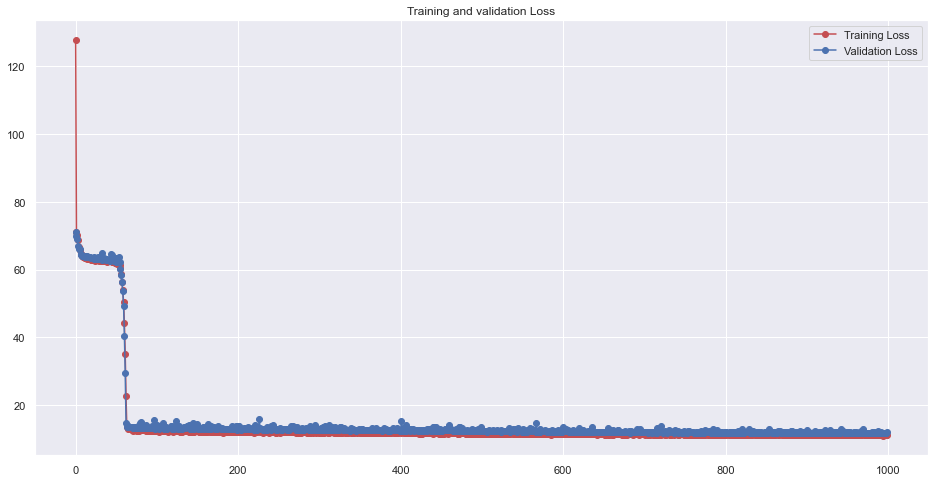

<Figure size 432x288 with 0 Axes>

In [20]:
#Graficar Epochs

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0,len(loss))
fig = plt.gcf()
fig.set_size_inches(16, 8)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss')
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()